In [2]:
%load_ext watermark
%watermark -a Chan -d -v -p numpy,pandas,sklearn,konlpy,tensorflow,matplotlib,imblearn

Chan 2019-08-07 

CPython 3.7.3
IPython 7.6.1

numpy 1.16.4
pandas 0.24.2
sklearn 0.21.2
konlpy 0.5.1
tensorflow 1.13.1
matplotlib 3.1.0
imblearn 0.5.0


In [46]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from konlpy.tag import Okt
import tensorflow as tf
from tensorflow.python.keras.preprocessing import sequence
from tensorflow import keras
from tqdm import tqdm
from collections import Counter
from matplotlib import pyplot as plt
import pickle

# Load datasets

In [4]:
datasets = pd.DataFrame()
for i in range(1,5):
    print(i)
    dump = pd.read_csv("../../data/sample ({}).csv".format(i), engine='python',names=['chat','label'])
    datasets = pd.concat([datasets, dump])
datasets.head()

1
2
3
4


,chat,label
0,자기잘못인거알면 중고딩도 먼저사과하는걸아는데,0
1,싹둑이 채팅창 관리 중입니다,0
2,싹둑이 채팅창 관리 중입니다,0
3,어제 어글 아직도 가? 개인적으로 사과하셨대 그만해 칭구들앙,0
4,케읍이 뭔데요 무슨사건있엇음?,0


In [5]:
datasets.reset_index(drop=True,inplace=True)

In [6]:
datasets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 2 columns):
chat     3500 non-null object
label    3500 non-null int64
dtypes: int64(1), object(1)
memory usage: 54.8+ KB


In [7]:
datasets.label = datasets.label.astype('int')

In [50]:
len(datasets[datasets.label ==1])/ len(datasets) # 유해한 레이블의 데이터가 많이 부족함 데이터 편향ㅠㅠ

0.13914285714285715

# Tokenize
## 형태소분석

In [9]:
morp = Okt()

C:\Users\skarn\Anaconda3\envs\DataAnalysis\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


In [10]:
morped = [morp.pos(_, norm=True, join=True) for _ in tqdm(datasets.chat)] # Stemming은 하지 않는다.

100%|█████████████████████████████████████████████████████████████████████████████| 3500/3500 [00:31<00:00, 112.83it/s]


In [11]:
morped[:5]

[['자기/Noun',
  '잘못/Noun',
  '인거/Josa',
  '알/Noun',
  '면/Josa',
  '중/Noun',
  '고딩/Noun',
  '도/Josa',
  '먼저/Noun',
  '사과/Noun',
  '하/Suffix',
  '는/Josa',
  '걸아는데/Verb'],
 ['싹둑/Noun',
  '이/Josa',
  '채팅/Noun',
  '창/Noun',
  '관리/Noun',
  '중/Noun',
  '입니다/Adjective'],
 ['싹둑/Noun',
  '이/Josa',
  '채팅/Noun',
  '창/Noun',
  '관리/Noun',
  '중/Noun',
  '입니다/Adjective'],
 ['어제/Noun',
  '어글/Noun',
  '아직도/Adverb',
  '가/Verb',
  '?/Punctuation',
  '개인/Noun',
  '적/Suffix',
  '으로/Josa',
  '사과/Noun',
  '하셨대/Verb',
  '그만해/Adjective',
  '칭구들앙/Noun'],
 ['케읍/Noun',
  '이/Josa',
  '뭔/Modifier',
  '데/Noun',
  '요/Josa',
  '무슨/Modifier',
  '사건/Noun',
  '있/Adjective',
  '엇음/Noun',
  '?/Punctuation']]

## Dictionary
최빈 형태소에 대한 단어사전 구성

In [48]:
vocab_size = 5000

pad_id = 0
oov_id = 1
index_offset = 1

def make_vocab(sentences):
    word_counter = Counter()

    for sent in sentences:
        word_counter.update(sent)

    most_common = word_counter.most_common()
    print("고빈도 단어:")
    for k, v in most_common[:10]:
        print(k, ": ", v)

        vocab = {
        '<PAD>': pad_id,
        '<OOV>': oov_id
        }
    for i, (word, cnt) in enumerate(most_common, start=index_offset+1):
        vocab[word] = i
        if len(vocab) >= vocab_size:
            break

    return vocab

word_index = make_vocab(morped)
word_inverted_index = {v:k for k, v in word_index.items()}

print("\n단어 사전:")
for i in range(0, 10):
    print(i, word_inverted_index[i])

print("\n단어 사전 크기: ", len(word_index))

# vocab save
with open('./vocab/vocab_index.pickle', 'wb') as f:
    pickle.dump(word_index, f, pickle.HIGHEST_PROTOCOL)
with open('./vocab/vocab_inverted_index.pickle', 'wb') as f:
    pickle.dump(word_inverted_index, f, pickle.HIGHEST_PROTOCOL)

고빈도 단어:
형/Suffix :  724
이/Josa :  706
샤/Noun :  587
나왔/Verb :  562
브베/Noun :  442
창/Noun :  420
채팅/Noun :  417
중/Noun :  408
입니다/Adjective :  408
싹둑/Noun :  407

단어 사전:
0 <PAD>
1 <OOV>
2 형/Suffix
3 이/Josa
4 샤/Noun
5 나왔/Verb
6 브베/Noun
7 창/Noun
8 채팅/Noun
9 중/Noun

단어 사전 크기:  3421


In [13]:
def index_to_text(indexes):
    return ' '.join([word_inverted_index[i] for i in indexes])

def text_to_index(tokens):
    indexes = []
    for tok in tokens:
        if tok in word_index:
            indexes.append(word_index[tok])
        else:
            indexes.append(oov_id)

    return indexes

print("원본: ", morped[0])
ids = text_to_index(morped[0])
print("문자 -> 숫자: ", ids)
print("숫자 -> 문자: ", index_to_text(ids))

원본:  ['자기/Noun', '잘못/Noun', '인거/Josa', '알/Noun', '면/Josa', '중/Noun', '고딩/Noun', '도/Josa', '먼저/Noun', '사과/Noun', '하/Suffix', '는/Josa', '걸아는데/Verb']
문자 -> 숫자:  [234, 781, 782, 381, 293, 9, 1292, 58, 1293, 235, 93, 60, 1294]
숫자 -> 문자:  자기/Noun 잘못/Noun 인거/Josa 알/Noun 면/Josa 중/Noun 고딩/Noun 도/Josa 먼저/Noun 사과/Noun 하/Suffix 는/Josa 걸아는데/Verb


# Padding

In [14]:
x_variable = [text_to_index(_) for _ in morped]

sentence_size = 20
x_padded = sequence.pad_sequences(x_variable,
                                 maxlen=sentence_size,
                                 truncating='post',
                                 padding='post',
                                 value=pad_id)

# Data Split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(x_padded, datasets.label)

print("train_inputs shape: ", X_train.shape)
print("test_inputs shape: ", X_test.shape)
print("train_labels shape: ", y_train.shape)
print("test_labels shape: ", y_test.shape)

train_inputs shape:  (2625, 20)
test_inputs shape:  (875, 20)
train_labels shape:  (2625,)
test_labels shape:  (875,)


# Model

In [16]:
import warnings
warnings.filterwarnings(action='once')

In [17]:
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, 10),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation=tf.nn.sigmoid)
])

C:\Users\skarn\Anaconda3\envs\DataAnalysis\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [18]:
def plot_loss(history):
    plt.figure(figsize=(6,5))
    val = plt.plot(history.epoch, history.history['val_loss'],
                 '--', label='Test')
    plt.plot(history.epoch, history.history['loss'], color=val[0].get_color(),
           label='Train')

    plt.xlabel('Epochs')
    plt.ylabel("Loss")
    plt.legend()

    plt.xlim([0,max(history.epoch)])

def eval_model(model):
    test_loss, test_acc = model.evaluate(X_test, pd.get_dummies(y_test))
    print('Test accuracy:', test_acc)

Train on 2625 samples, validate on 875 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/5
2625/2625 [==============================] - ETA: 3:08 - loss: 0.7088 - acc: 0.218 - ETA: 46s - loss: 0.7020 - acc: 0.359 - ETA: 19s - loss: 0.6925 - acc: 0.50 - ETA: 14s - loss: 0.6872 - acc: 0.55 - ETA: 10s - loss: 0.6817 - acc: 0.60 - ETA: 8s - loss: 0.6732 - acc: 0.6414 - ETA: 6s - loss: 0.6682 - acc: 0.662 - ETA: 5s - loss: 0.6577 - acc: 0.695 - ETA: 4s - loss: 0.6445 - acc: 0.722 - ETA: 3s - loss: 0.6387 - acc: 0.725 - ETA: 2s - loss: 0.6275 - acc: 0.737 - ETA: 2s - loss: 0.6126 - acc: 0.749 - ETA: 1s - loss: 0.6025 - acc: 0.756 - ETA: 1s - loss: 0.5851 - acc: 0.768 - ETA: 1s - loss: 0.5813 - acc: 0.770 - ETA: 0s - loss: 0.5730 - acc: 0.775 - ETA: 0s - loss: 0.5681 - acc: 0.778 - ETA: 0s - loss: 0.5570 - acc: 0.784 - ETA: 0s - loss: 0.5530 - acc: 0.787 - ETA: 0s - loss: 0.5474 - acc: 0.790 - 4s 2ms/s

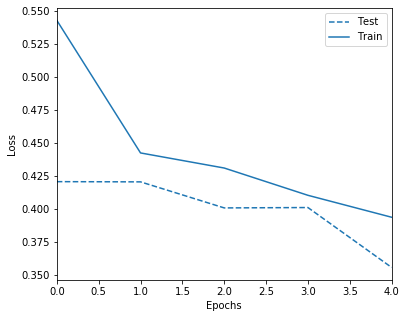

In [19]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train,
          pd.get_dummies(y_train),
          epochs=5,
          validation_data=(X_test, pd.get_dummies(y_test))
         )
plot_loss(history)
eval_model(model)

In [20]:
set(model.predict_classes(X_test)) ## 전부 0으로 예측을 함 . 데이터 불균형 문제때문

{0}

In [21]:
# result = pd.DataFrame(np.apply_along_axis(index_to_text, 1, X_test))
# result['predict'] = model.predict_proba(X_test)[:,1] # 유해하다고 판별할 확률
# result[result.predict>0.3]


# 데이터 클래스 불균형 문제 해결하자

In [22]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

## upsampling
- 딥러닝은 데이터가 많을수록 좋다.
- 보다 많은 데이터 사용을 위해 upsampling을 사용하자!

In [23]:
up_X, up_y = RandomOverSampler().fit_resample(x_padded, datasets.label)
up_X_train, up_X_test, up_y_train, up_y_test = train_test_split(up_X, up_y)

In [24]:
# 총 데이터 수 , 1 레이블 데이터 수
len(up_y), up_y.sum()

(6026, 3013)

C:\Users\skarn\Anaconda3\envs\DataAnalysis\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Train on 4519 samples, validate on 1507 samples
Epoch 1/5
4519/4519 [==============================] - ETA: 4:22 - loss: 0.9109 - acc: 0.562 - ETA: 43s - loss: 0.7663 - acc: 0.541 - ETA: 23s - loss: 0.7211 - acc: 0.52 - ETA: 17s - loss: 0.7021 - acc: 0.52 - ETA: 13s - loss: 0.6978 - acc: 0.51 - ETA: 10s - loss: 0.6852 - acc: 0.50 - ETA: 8s - loss: 0.6763 - acc: 0.5043 - ETA: 7s - loss: 0.6715 - acc: 0.508 - ETA: 6s - loss: 0.6641 - acc: 0.506 - ETA: 5s - loss: 0.6583 - acc: 0.508 - ETA: 4s - loss: 0.6517 - acc: 0.516 - ETA: 4s - loss: 0.6502 - acc: 0.521 - ETA: 3s - loss: 0.6452 - acc: 0.531 - ETA: 3s - loss: 0.6418 - acc: 0.542 - ETA: 2s - loss: 0.6352 - acc: 0.554 - ETA: 2s - loss: 0.6311 - acc: 0.563 - ETA: 2s - loss: 0.6252 - acc: 0.578 - ETA: 2s - loss: 0.6201 - acc: 0.589 - ETA: 1s - loss: 0.6173 - acc: 0.595 - ETA: 1s - loss: 0.6133 - acc: 0.605 - ETA: 1s - loss: 0.6104 - acc: 0.611 - ETA: 1s - loss: 0.6059 - acc: 0.617 - ETA: 1s - loss: 0.6017 - acc: 0.624 - ETA: 0s - loss: 0.5

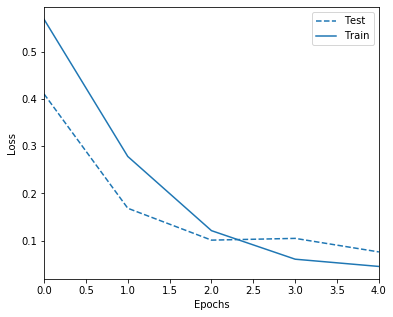

In [25]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(up_X_train,
          pd.get_dummies(up_y_train),
          epochs=5,
          validation_data=(up_X_test, pd.get_dummies(up_y_test))
         )
plot_loss(history)
test_loss, test_acc = model.evaluate(up_X_test, pd.get_dummies(up_y_test))
print('Test accuracy:', test_acc)

In [26]:
result = pd.DataFrame(np.apply_along_axis(index_to_text, 1, up_X_test))
result['predict'] = model.predict_proba(up_X_test)[:,1] # 유해하다고 판별할 확률
print('전체채팅수{}, 유해채팅수{}'.format(len(result),len(result[result.predict>0.5])))
result[result.predict>0.5].head(10)
result['label'] = up_y_test

전체채팅수1507, 유해채팅수785


In [27]:
result.to_csv('../../data/cnn_result.csv', encoding='utf-16')

## 분류 애매한 채팅들

In [28]:
result[(result.predict>0.3) & (result.predict<0.6)]

,0,predict,label
6,카톡/Noun 닉/Noun 인/Noun 싸/Verb 컴/Noun 으로/Josa 바꾸...,0.393249,0
70,몰라서/Verb 물어보는건데/Verb <PAD> <PAD> <PAD> <PAD> <...,0.544840,0
143,도/Noun 네/Josa 하시면/Verb 브베/Noun 가/Josa 신고/Noun ...,0.530026,0
170,도내/Noun 가/Josa 질못/Verb 햇/Noun 네/Josa <PAD> <PA...,0.448002,0
209,아/Exclamation 시/Noun 크러/Verb <PAD> <PAD> <PAD>...,0.418018,0
448,이/Determiner 새끼/Noun 오/Modifier 자마자/Noun 왜/Nou...,0.517955,0
587,인사/Noun 도/Josa 안/VerbPrefix 할래/Verb <PAD> <PAD...,0.423173,0
809,ㅄ/KoreanParticle 아/Exclamation <PAD> <PAD> <PA...,0.327777,1
826,도/Noun 네/Noun 벌써/Noun 터지네/Verb <PAD> <PAD> <PA...,0.371224,0
962,ㅋㅋㅋ/KoreanParticle 어디서/Adverb 가르쳐/Verb ?/Punct...,0.473200,0


### 예측 실패한 채팅들

In [29]:
result[model.predict_classes(up_X_test) != up_y_test]

,0,predict,label
70,몰라서/Verb 물어보는건데/Verb <PAD> <PAD> <PAD> <PAD> <...,0.544840,0
112,다/Adverb 읽어놓고/Verb 당황/Noun 한/Josa 척/Noun 하네/Ve...,0.870334,0
116,아니/Adjective 병신/Noun 아/Josa 감마/Noun 를/Josa 키라/...,0.996563,0
143,도/Noun 네/Josa 하시면/Verb 브베/Noun 가/Josa 신고/Noun ...,0.530026,0
174,뮤비/Noun 할/Verb 수/Noun 있어/Adjective 넌/Noun 너/No...,0.648723,0
234,브베/Noun 야/Josa 내/Determiner 말/Noun 들리니/Verb <P...,0.963139,0
292,Squid/Alpha 1/Number <PAD> <PAD> <PAD> <PAD> <...,0.068937,1
315,매력/Noun 쏜/Noun 님/Suffix 앵/Noun 냥/Josa ~/Punctu...,0.955559,0
322,건물/Noun 에/Josa 깔려/Verb 뒤져라/Verb <PAD> <PAD> <P...,0.009652,1
326,오늘/Noun 도/Josa 30분/Number 지각/Noun 했샤/Noun 벌받으샤...,0.895348,0


# 시11111발 의 경우

In [30]:
test_chat = "시1111발"
test_id = text_to_index(morp.pos(test_chat, norm=True, join=True))
print(morp.pos(test_chat, norm=True, join=True))
sentence_size = 20
x_padded = sequence.pad_sequences([test_id],
                                 maxlen=sentence_size,
                                 truncating='post',
                                 padding='post',
                                 value=pad_id)

['시/Noun', '1111/Number', '발/Noun']


In [31]:
model.predict(x_padded)

array([[0.19393216, 0.81546557]], dtype=float32)

## 모델 체크포인트 저장

In [42]:
model.save('../model/cnn_oversample.h5')

In [39]:
# tf.contrib.saved_model.save_keras_model(model, '../model/')


Consider using a TensorFlow optimizer from `tf.train`.


C:\Users\skarn\Anaconda3\envs\DataAnalysis\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ../model/1565178937\saved_model.pb


b'../model/1565178937'

# TODO
- 형태소별 Tokenize 말고 한글 자모별 Tokenize 하여 실험해보기
- CNN layer / Parameter 변경시켜보기
- 예측 결과 검정하기
    - Attention 이용